In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels as stats
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
data = pd.read_excel("Downloads/Final_RA_data.xlsx")

### Creating df by deleting all rows with missing values

In [88]:
df=data[['Companies','sgna','fyear','current_assets','age', 'ppe', 'emp', 'operating_expenses','liabilities', 'book_value','gross_profit','Litigation', 'Numbers', 'developed', 'Multinational', 'Australia', 'Belgium', 'Germany', 'India', 'Ireland', 'Norway', 'Singapore', 'Sweden', 'UK', 'USA', 
      'policy_reforms_australia', 'policy_reforms_germany', 'policy_reforms_india', 'policy_reforms_NORWAY', 'policy_reforms_SINGAPORE', 'policy_reforms_SWEDEN','policy_reforms_UK',
      'policy_reforms_usa', 'GDP per capita growth (annual %)', 'Life expectancy at birth, total (years)', 'Mortality rate, infant (per 1,000 live births)', 
      'Population, total', 'Individuals using the Internet (% of population)', 'Physicians (per 1,000 people)','acquisitions']]
print("Shape of Data:", df.shape)
df.isnull().sum()

Shape of Data: (3158, 40)


Companies                                              0
sgna                                                1011
fyear                                                  0
current_assets                                       305
age                                                    1
ppe                                                  835
emp                                                 1153
operating_expenses                                   369
liabilities                                          656
book_value                                          1022
gross_profit                                         463
Litigation                                             1
Numbers                                                0
developed                                              0
Multinational                                        569
Australia                                              0
Belgium                                                0
Germany                        

In [89]:
df.dropna(inplace=True)
print("Shape of Data after removing Missing values:", df.shape)

Shape of Data after removing Missing values: (873, 40)


### Variable Creation

##### Create a quadratic term for SGNA (SQ_SGNA)

In [23]:
df['SQ_SGNA'] = (df['sgna'])**2

### Find the lag of SGNA at the company and fyear level
Selection of optimal lag at Company and fyear level -

I looked at the acf plots for each company and fyear level and found that lags 1 and 2 have the significant correlation with the presnt sgna as shown below-

In order to to get the optimal lag for every company, I have fit an OLS model to predict sgna from it's lag. I have compared the Information Criterion - AIC for lag 1, 2 and 3 and chosen the lag with the lowest AIC as the optimal lag

#### Function to find the optimal lag for every Company at fyear level

In [24]:
import statsmodels.api as sm
aic_dict = {}
df_lag=pd.DataFrame()
def get_optimal_lag(company_name):
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(1)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag1'] = model.aic
    
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(2)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag2'] = model.aic
    
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(3)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag3'] = model.aic  
    return min(aic_dict, key=aic_dict.get)

#### Dictionary to store the Company and its corresponding optimal lag - optimal_lag_dict

In [25]:
optimal_lag_dict = {}
for i in set(df['Companies']):
    #optimal_lag_list.append(get_optimal_lag(i))
    optimal_lag_dict[i] = get_optimal_lag(i)    

#### Setting lag for every company using the optimal_lag_dict

In [26]:
for i in set(df['Companies']):
    if(optimal_lag_dict[i]=='lag1'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(1)
    if(optimal_lag_dict[i]=='lag2'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(2)
    if(optimal_lag_dict[i]=='lag3'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(3)   

#### Creating SGNA_MKT varables for by finding the moving average of SGNA for each firm for 3 years

In [29]:
for i in set(df['Companies']):
    df.loc[df.Companies==i,'sgna_mkt']=df[df.Companies==i].sgna.rolling(window=3).mean()

#### Removing rows with missing lag_sgna, sgna_mkt

In [31]:
df.dropna(inplace=True)

#### Create interaction terms for interaction of SGNA with litigation, numbers of cases, developed, multinational, Australia, Belgium, Germany, India, Ireland, Norway, Singapore, Sweden, UK, USA, policy_reform_Australia, policy_reform_Belgium, policy_reform_Germany, policy_reform_India, policy_reform_Ireland, policy_reform_Norway, policy_reform_Singapore, policy_reform_Sweden, policy_reform_UK, policy_reform_USA, gdp per capita growth, life expectancy, mortality, population, Individuals using the Internet, physicians, acquisitions

In [41]:
df['sgna_litigation'] = df['sgna'] * df['Litigation']
df['sgna_no_of_cases'] = df['sgna'] * df['Numbers']
df['sgna_developed'] = df['sgna'] * df['developed']
df['sgna_multinational'] = df['sgna'] * df['Multinational']
df['sgna_Australia'] = df['sgna'] * df['Australia']
df['sgna_Belgium'] = df['sgna'] * df['Belgium']
df['sgna_Germany'] = df['sgna'] * df['Germany']
df['sgna_India'] = df['sgna'] * df['India']
df['sgna_Ireland'] = df['sgna'] * df['Ireland']
df['sgna_Norway'] = df['sgna'] * df['Norway']
df['sgna_Singapore'] = df['sgna'] * df['Singapore']
df['sgna_Sweden'] = df['sgna'] * df['Sweden']
df['sgna_UK'] = df['sgna'] * df['UK']
df['sgna_USA'] = df['sgna'] * df['USA']
df['sgna_policy_reform_Australia'] = df['sgna'] * df['policy_reforms_australia']
df['sgna_policy_reform_Germany'] = df['sgna'] * df['policy_reforms_germany']
df['sgna_policy_reform_India'] = df['sgna'] * df['policy_reforms_india']
df['sgna_policy_reform_Norway'] = df['sgna'] * df['policy_reforms_NORWAY']
df['sgna_policy_reform_Singapore'] = df['sgna'] * df['policy_reforms_SINGAPORE']
df['sgna_policy_reform_Sweden'] = df['sgna'] * df['policy_reforms_SWEDEN']
df['sgna_policy_reform_UK'] = df['sgna'] * df['policy_reforms_UK']
df['sgna_policy_reform_USA'] = df['sgna'] * df['policy_reforms_usa']
df['sgna_gdp per capita growth'] = df['sgna'] * df['GDP per capita growth (annual %)']
df['sgna_population'] = df['sgna'] * df['Population, total']
df['sgna_Individuals_using _the_Internet'] = df['sgna'] * df['Individuals using the Internet (% of population)']
df['sgna_physicians'] = df['sgna'] * df['Physicians (per 1,000 people)']
df['sgna_acquisitions'] = df['sgna'] * df['acquisitions']
df['sgna_mortality'] = df['sgna'] * df['Mortality rate, infant (per 1,000 live births)']
df['sgna_life_expectancy'] = df['sgna'] * df['Life expectancy at birth, total (years)']

In [42]:
df.isnull().sum()

Companies                               0
sgna                                    0
fyear                                   0
current_assets                          0
age                                     0
ppe                                     0
emp                                     0
operating_expenses                      0
liabilities                             0
book_value                              0
gross_profit                            0
Litigation                              0
Numbers                                 0
developed                               0
Multinational                           0
Australia                               0
Belgium                                 0
Germany                                 0
India                                   0
Ireland                                 0
Norway                                  0
Singapore                               0
Sweden                                  0
UK                                

### Functions for all Training Models to be used in our analysis

#### Function to draw Scatter plot

In [32]:
def scatter_plot(x,y):
    colors = (0,0,0)
    area = np.pi*3
    plt.scatter(x = x, y = y, s=area, c=colors, alpha=0.5)
    plt.title('Scatter plot')
    plt.show()

#### Function to print model metrics MAE, MSE, RMSE and R-squared

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
def printMetrics(y_actual,y_predicted):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_actual, y_predicted))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_actual, y_predicted))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_actual, y_predicted)))
    print('R-squared:',metrics.r2_score(y_actual, y_predicted))

#### Functions for Linear, Ridge, ElasticNet and Lasso Regression

In [34]:
#Linear Regression
from sklearn.linear_model import LinearRegression
def LinearReg(iv,dv):
    lm = LinearRegression()
    lm.fit(iv,dv)
    return lm

#Lasso Regression
from sklearn.linear_model import Lasso
def LassoReg(iv,dv):
    lasso = Lasso()
    lasso.fit(iv,dv)
    return lasso

#Ridge Regression
from sklearn.linear_model import Ridge
def RidgeReg(iv,dv):
    ridge = Ridge()
    ridge.fit(iv,dv)
    return ridge
        
#ElasticNet Regression
from sklearn.linear_model import ElasticNet
def ElasticNetReg(iv,dv):
    elastic = ElasticNet()
    elastic.fit(iv,dv)
    return elastic

#### Functions for Support Vector Regression

In [35]:
#Support Vector Regression with Kernel RBF
from sklearn.svm import SVR
def SVR_RBF(iv,dv):
    svr = SVR(kernel='rbf')
    svr.fit(iv,dv)
    return svr

#Linear Support Vector Regression
from sklearn.svm import LinearSVR
def SVR_Linear(iv,dv):
    lsvr = LinearSVR(random_state=0, tol=1e-5)
    lsvr.fit(iv,dv)
    return lsvr

#### Function for XGBoost with different Tuning parameters 

In [36]:
import xgboost as xgb
def XGBoostReg(iv,dv,max_depth,objective,n_estimators,learning_rate):
    data_dmatrix = xgb.DMatrix(data=iv,label=dv)
    xg_reg = xgb.XGBRegressor(objective =objective, colsample_bytree = 0.3, learning_rate = learning_rate,
                    max_depth = max_depth, alpha = 10, n_estimators = n_estimators)
    xg_reg.fit(iv,dv)
    return xg_reg

#### Function for AdaBoost with different Tuning parameters

In [37]:
from sklearn.ensemble import AdaBoostRegressor
def AdaBoost(iv,dv,n_estimators,learning_rate):
    ada = AdaBoostRegressor(n_estimators=n_estimators,
                             learning_rate=learning_rate)
    ada.fit(iv,dv)
    return ada

#### Function for Decision Tree Regression with different Tuning parameters

In [38]:
from sklearn.tree import DecisionTreeRegressor
def DecisionTreeReg(iv,dv,max_depth):
    dec = DecisionTreeRegressor(max_depth=max_depth)
    dec.fit(iv,dv)
    return dec

#### Orthogonal Matching Pursuit Function

In [39]:
from sklearn.linear_model import OrthogonalMatchingPursuit

def OrthogonalMatchReg(iv,dv):
    orth = OrthogonalMatchingPursuit().fit(iv, dv)
    return orth

#### Bayesian Ridge Regression Function

In [43]:
from sklearn import linear_model
def BayesianRidgeReg(iv,dv):
    bridge = linear_model.BayesianRidge().fit(iv, dv)
    return bridge

#### Function for Robust Linear Model Estimation using RANSAC

In [44]:
from sklearn import linear_model
def RansacReg(iv,dv):
    ransac = linear_model.RANSACRegressor().fit(iv,dv)
    return ransac

#### RandomForest Regression Function

In [45]:
from sklearn.ensemble import RandomForestRegressor
def RandomForestReg(iv,dv,n_estimators,random_state):
    rf = RandomForestRegressor(n_estimators = n_estimators, random_state = random_state)
    rf.fit(iv,dv)
    return rf

#### Gradient Boosting Regression Function

In [46]:
from sklearn import ensemble
def GradientBoostReg(iv,dv,n_estimators,max_depth,learning_rate,criterion):
    gbreg = ensemble.GradientBoostingRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                               learning_rate=learning_rate,criterion=criterion)
    gbreg.fit(iv,dv)
    return gbreg

#### Function for forward-backward Feature selection based on p-value from statsmodels.api.OLS

In [47]:
import statsmodels.formula.api as smf

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#### Function to predict Growth_In_Profit using a Specified Model

In [48]:
def RegPredict(lm,iv,dv):
    y_pred= lm.predict(iv)
    printMetrics(dv,y_pred)
    return y_pred

#### Function to plot Feature Importances 

In [49]:
def plot_feature_imp(lm,index):
    a=lm.coef_.tolist()
    flat_coeff_list = [val for sublist in a for val in sublist]
    feature_imp = pd.Series(flat_coeff_list, index=index).sort_values(ascending=True)
    feature_imp.plot(kind='barh', title='Feature Importance')
    plt.show()

In [50]:
# Feature Importance function fro ElasticNet
def plot_feature_imp_EN(lm,index):
    feature_imp = pd.Series(lm.coef_, index=index).sort_values(ascending=True)
    feature_imp.plot(kind='barh', title='Feature Importance')
    plt.show()

### a.	Estimate a regression model with SGNA as dependent variable and lag_sgna and sgna_mkt as independent variables. Store the residual of the model NAMED AS “R1”

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


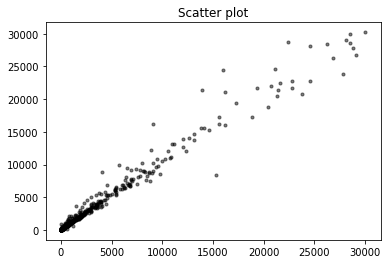

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


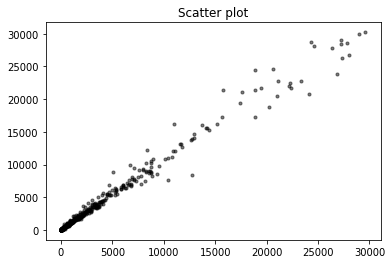

Linear Regression Metrics
Mean Absolute Error: 271.88766987790683
Mean Squared Error: 391876.9797786827
Root Mean Squared Error: 626.0007825703436
R-squared: 0.9857676434679824


In [51]:
x1 = df[['lag_sgna', 'sgna_mkt']]
y1 = df['sgna']
scatter_plot(x = x1['lag_sgna'], y = y1)
scatter_plot(x = x1['sgna_mkt'], y = y1)
x1.fillna(0,inplace=True)
print("Linear Regression Metrics")
rd=LinearReg(x1,y1)
pred=RegPredict(rd,x1,y1)

Distribution of residuals


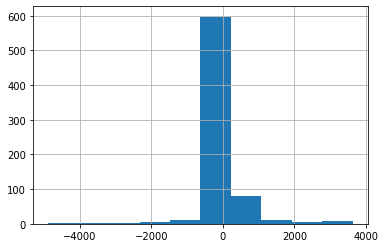

In [52]:
df['R1'] = df['sgna'] - pred
print("Distribution of residuals")
df['R1'].hist()

### Model 3: Estimate a set of models for each interaction effect

#### Defining Variables

In [55]:
DV = ['gross_profit']
IV = ['sgna', 'SQ_SGNA']
MV = ['Litigation', 'Numbers', 'developed', 'Multinational', 'Australia', 'Belgium', 'Germany', 'India', 'Ireland', 'Norway', 'Singapore', 'Sweden', 'UK', 'USA', 
      'policy_reforms_australia', 'policy_reforms_germany', 'policy_reforms_india', 'policy_reforms_NORWAY', 'policy_reforms_SINGAPORE', 'policy_reforms_SWEDEN','policy_reforms_UK',
      'policy_reforms_usa', 'GDP per capita growth (annual %)', 'Life expectancy at birth, total (years)', 'Mortality rate, infant (per 1,000 live births)', 
      'Population, total', 'Individuals using the Internet (% of population)', 'Physicians (per 1,000 people)','acquisitions']
INT_V = ['sgna_litigation', 'sgna_no_of_cases', 'sgna_developed', 'sgna_multinational',
     'sgna_Australia', 'sgna_Belgium', 'sgna_Germany', 'sgna_India', 'sgna_Ireland', 'sgna_Norway', 
     'sgna_Singapore', 'sgna_Sweden', 'sgna_UK', 'sgna_USA', 'sgna_policy_reform_Australia',
     'sgna_policy_reform_Germany', 'sgna_policy_reform_India', 'sgna_policy_reform_Norway', 'sgna_policy_reform_Singapore',
     'sgna_policy_reform_Sweden', 'sgna_policy_reform_UK', 'sgna_policy_reform_USA', 'sgna_gdp per capita growth', 'sgna_life_expectancy',
     'sgna_mortality','sgna_population', 'sgna_Individuals_using _the_Internet', 'sgna_physicians', 'sgna_acquisitions']
CV = ['current_assets','age', 'ppe', 'emp', 'operating_expenses','liabilities', 'book_value','R1']

In [57]:
np.mean(df['gross_profit'])

4669.625520110957

In [70]:
X = df[IV + CV]
y = df[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


### Linear Regression, XGBoost and Bayesian Ridge Regression Models had the best performance in terms of MAE, RMSE and R-squared

### Linear Regression

#### Checking model without Interaction Variables

Linear Regression Results - without Imputation
Mean Absolute Error: 311.5579091419331
Mean Squared Error: 469291.3554289408
Root Mean Squared Error: 685.0484329074411
R-squared: 0.9899077361247259


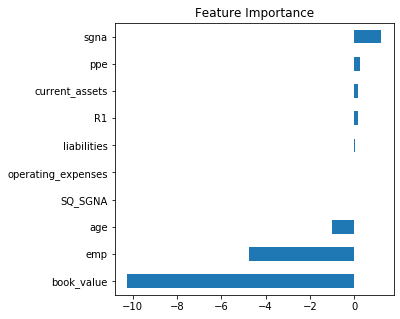

In [71]:
print("Linear Regression Results - without Imputation")
lr=LinearReg(X_train,y_train)
pred=RegPredict(lr,X_test,y_test)

#Plotting Feature Importances 
feature_list = list(X.columns)
plot_feature_imp(lr,index=feature_list)

#### Effect of adding each Moderating and Interacting Variable 

Effect of adding Moderating variable- Litigation and Interaction variable- sgna_litigation
Mean Absolute Error: 311.5283186806933
Mean Squared Error: 433188.3904219946
Root Mean Squared Error: 658.1704873526271
R-squared: 0.990684142178907


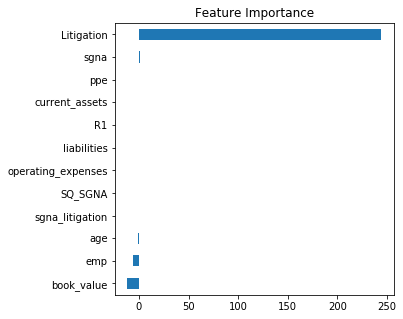

Effect of adding Moderating variable- Numbers and Interaction variable- sgna_no_of_cases
Mean Absolute Error: 313.78856276407066
Mean Squared Error: 471860.1631886544
Root Mean Squared Error: 686.9207837797998
R-squared: 0.9898524930748466


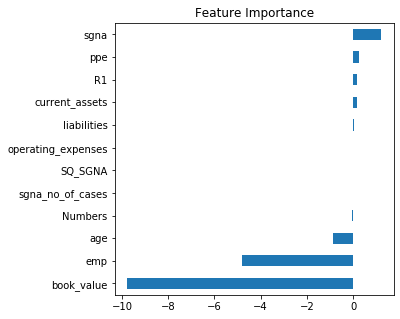

Effect of adding Moderating variable- developed and Interaction variable- sgna_developed
Mean Absolute Error: 311.55790914193346
Mean Squared Error: 469291.35542894265
Root Mean Squared Error: 685.0484329074425
R-squared: 0.9899077361247258


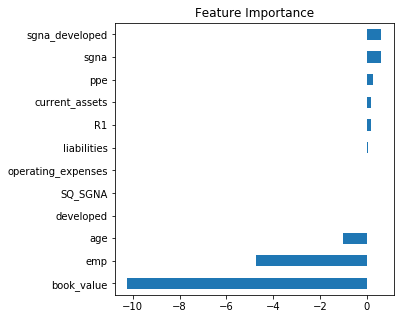

Effect of adding Moderating variable- Multinational and Interaction variable- sgna_multinational
Mean Absolute Error: 316.32151934001723
Mean Squared Error: 458628.33354778425
Root Mean Squared Error: 677.221037437397
R-squared: 0.9901370478929644


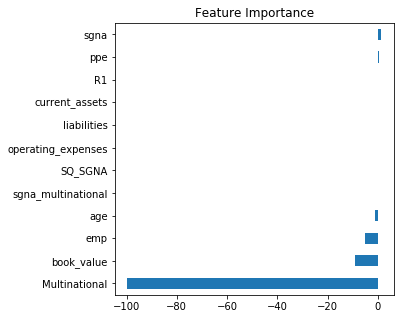

Effect of adding Moderating variable- Australia and Interaction variable- sgna_Australia
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


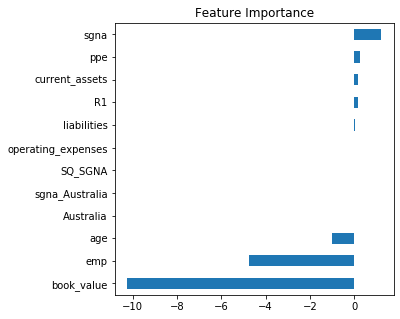

Effect of adding Moderating variable- Belgium and Interaction variable- sgna_Belgium
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


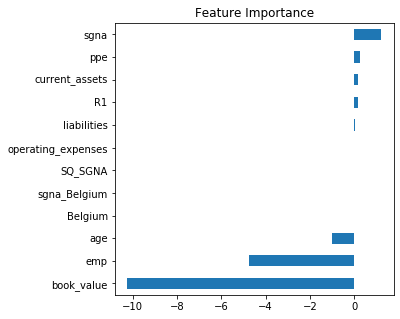

Effect of adding Moderating variable- Germany and Interaction variable- sgna_Germany
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


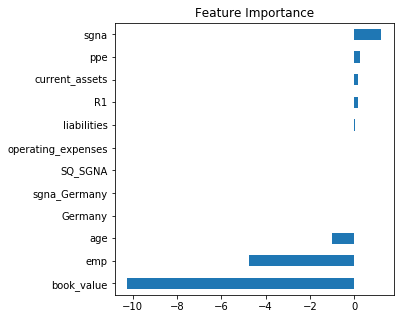

Effect of adding Moderating variable- India and Interaction variable- sgna_India
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


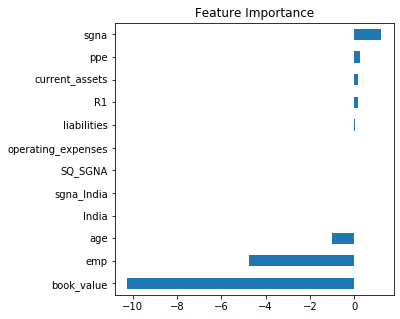

Effect of adding Moderating variable- Ireland and Interaction variable- sgna_Ireland
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


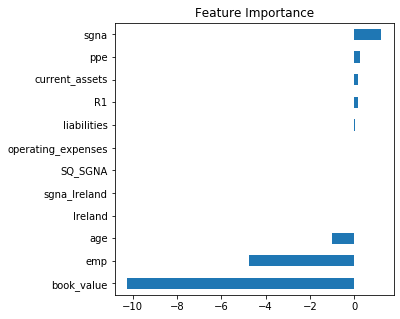

Effect of adding Moderating variable- Norway and Interaction variable- sgna_Norway
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


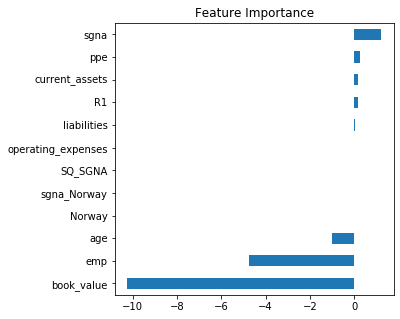

Effect of adding Moderating variable- Singapore and Interaction variable- sgna_Singapore
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


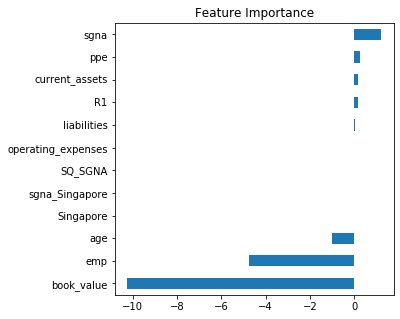

Effect of adding Moderating variable- Sweden and Interaction variable- sgna_Sweden
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


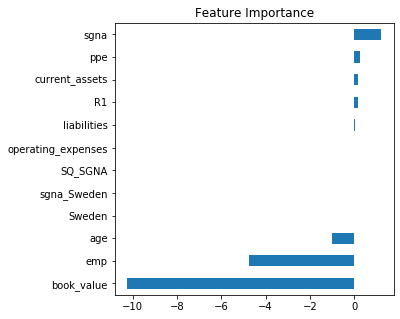

Effect of adding Moderating variable- UK and Interaction variable- sgna_UK
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


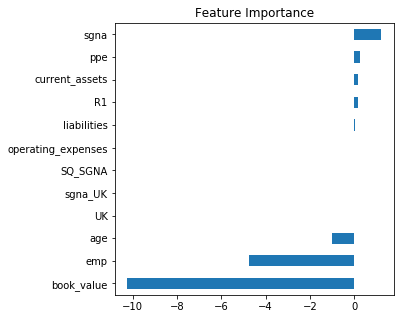

Effect of adding Moderating variable- USA and Interaction variable- sgna_USA
Mean Absolute Error: 311.55790914193346
Mean Squared Error: 469291.35542894265
Root Mean Squared Error: 685.0484329074425
R-squared: 0.9899077361247258


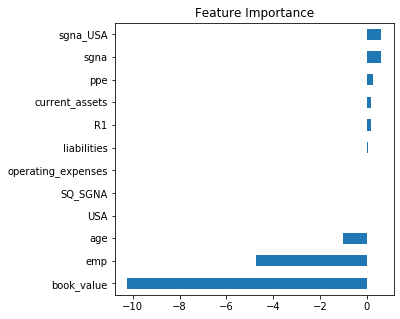

Effect of adding Moderating variable- policy_reforms_australia and Interaction variable- sgna_policy_reform_Australia
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


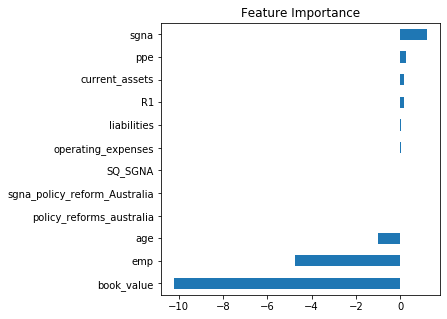

Effect of adding Moderating variable- policy_reforms_germany and Interaction variable- sgna_policy_reform_Germany
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


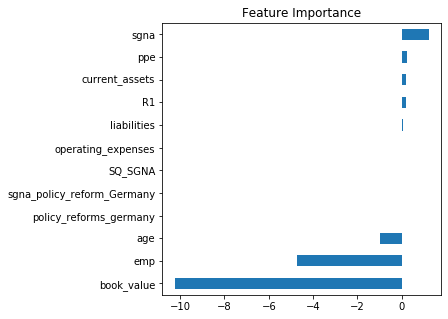

Effect of adding Moderating variable- policy_reforms_india and Interaction variable- sgna_policy_reform_India
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


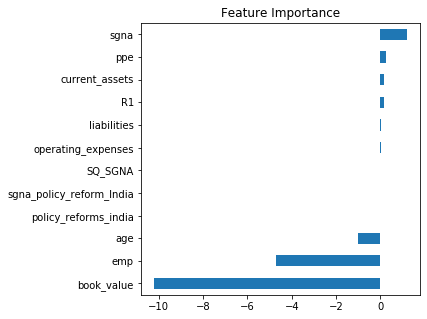

Effect of adding Moderating variable- policy_reforms_NORWAY and Interaction variable- sgna_policy_reform_Norway
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


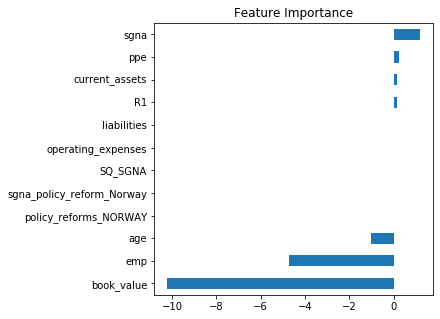

Effect of adding Moderating variable- policy_reforms_SINGAPORE and Interaction variable- sgna_policy_reform_Singapore
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


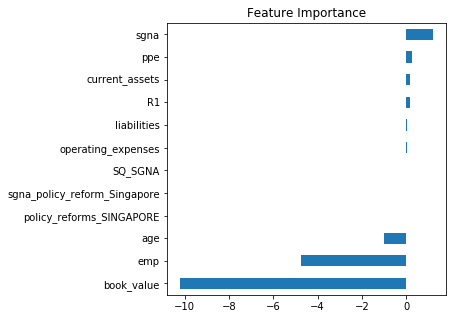

Effect of adding Moderating variable- policy_reforms_SWEDEN and Interaction variable- sgna_policy_reform_Sweden
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


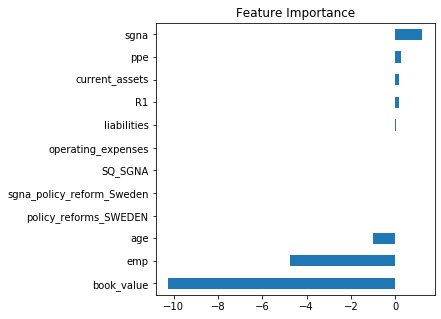

Effect of adding Moderating variable- policy_reforms_UK and Interaction variable- sgna_policy_reform_UK
Mean Absolute Error: 311.55790914193375
Mean Squared Error: 469291.3554289404
Root Mean Squared Error: 685.0484329074408
R-squared: 0.9899077361247259


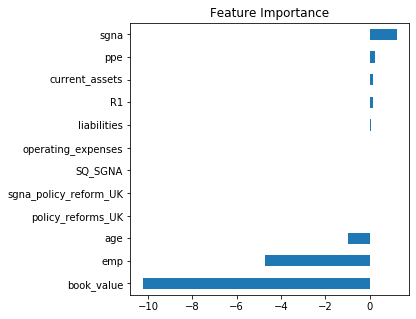

Effect of adding Moderating variable- policy_reforms_usa and Interaction variable- sgna_policy_reform_USA
Mean Absolute Error: 309.3514977345738
Mean Squared Error: 468859.3059405345
Root Mean Squared Error: 684.733018000837
R-squared: 0.9899170274900871


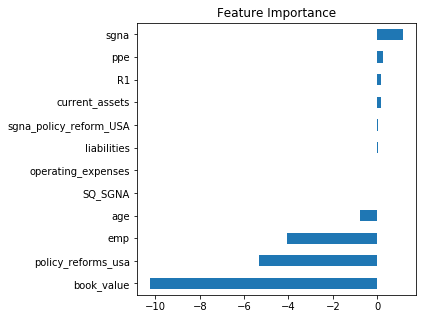

Effect of adding Moderating variable- GDP per capita growth (annual %) and Interaction variable- sgna_gdp per capita growth
Mean Absolute Error: 310.96989134633753
Mean Squared Error: 425242.1680900159
Root Mean Squared Error: 652.1059485160489
R-squared: 0.9908550282854977


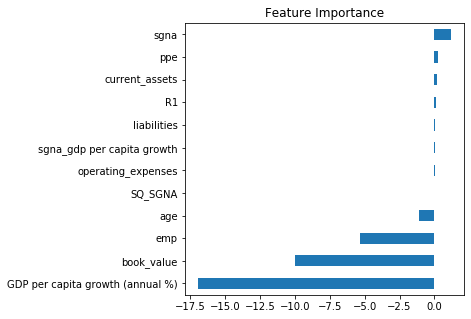

Effect of adding Moderating variable- Life expectancy at birth, total (years) and Interaction variable- sgna_life_expectancy
Mean Absolute Error: 323.8626646069452
Mean Squared Error: 450734.1108058408
Root Mean Squared Error: 671.3673441610345
R-squared: 0.9903068157313877


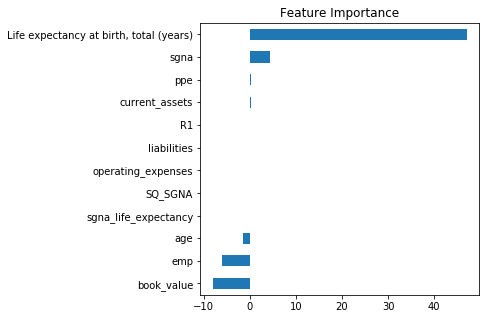

Effect of adding Moderating variable- Mortality rate, infant (per 1,000 live births) and Interaction variable- sgna_mortality
Mean Absolute Error: 315.6112546434625
Mean Squared Error: 463290.0793223765
Root Mean Squared Error: 680.6541554434061
R-squared: 0.9900367955274938


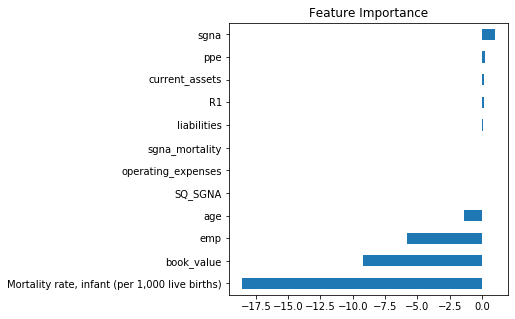

Effect of adding Moderating variable- Population, total and Interaction variable- sgna_population
Mean Absolute Error: 319.62029357883137
Mean Squared Error: 449806.21421831776
Root Mean Squared Error: 670.6759383027826
R-squared: 0.9903267704505656


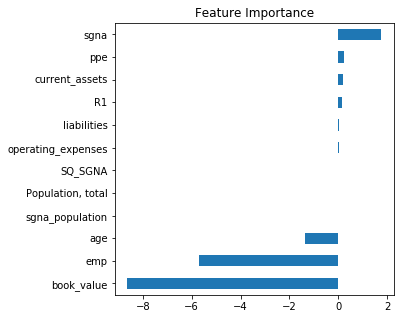

Effect of adding Moderating variable- Individuals using the Internet (% of population) and Interaction variable- sgna_Individuals_using _the_Internet
Mean Absolute Error: 318.8499348914991
Mean Squared Error: 437673.5142355007
Root Mean Squared Error: 661.5689791968035
R-squared: 0.9905876881263966


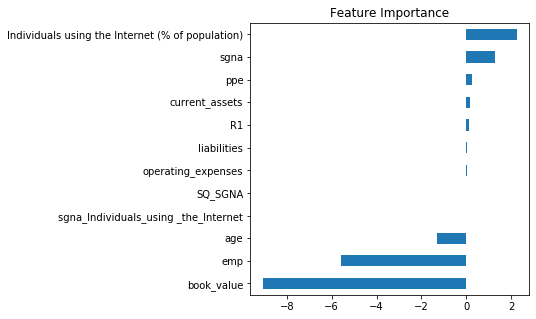

Effect of adding Moderating variable- Physicians (per 1,000 people) and Interaction variable- sgna_physicians
Mean Absolute Error: 310.06555927287286
Mean Squared Error: 471171.86697283306
Root Mean Squared Error: 686.4195997877923
R-squared: 0.9898672951097744


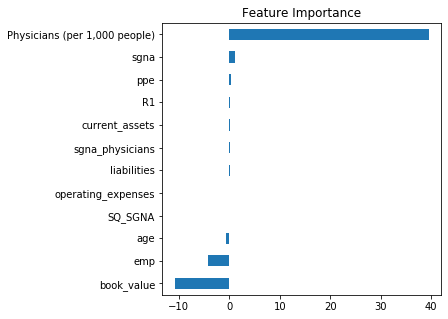

Effect of adding Moderating variable- acquisitions and Interaction variable- sgna_acquisitions
Mean Absolute Error: 314.5501911829716
Mean Squared Error: 481701.19726759515
Root Mean Squared Error: 694.0469705053075
R-squared: 0.9896408584227668


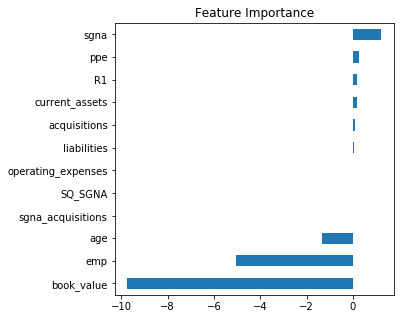

In [72]:
for i in range(0,29):
    X = df[IV+CV+[MV[i]]+[INT_V[i]]]
    y = df['gross_profit'].values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    lr=LinearReg(X_train,y_train)
    print("Effect of adding Moderating variable-",MV[i],"and Interaction variable-", INT_V[i])
    pred=RegPredict(lr,X_test,y_test)

    #Plotting Feature Importances 
    feature_list = list(X.columns)
    plot_feature_imp(lr,index=feature_list)    

### XGBoost Regression

#### Model without Interation and Moderating Variables

XGBoost Regression Results - Without Imputation
Mean Absolute Error: 386.883830313847
Mean Squared Error: 878193.133403236
Root Mean Squared Error: 937.119593970394
R-squared: 0.9811141698366501


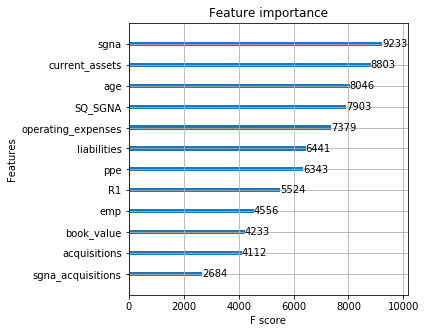

In [73]:
print("XGBoost Regression Results - Without Imputation")
xg=XGBoostReg(X_train,y_train,max_depth=50,objective ='reg:linear',n_estimators=400,learning_rate=0.1)
pred=RegPredict(xg,X_test,y_test)

xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

#### Effect of adding each Moderating and Interacting Variable 

Effect of adding Moderating variable- Litigation and Interaction variable- sgna_litigation
Mean Absolute Error: 359.7528812211135
Mean Squared Error: 650103.661053428
Root Mean Squared Error: 806.2900601231718
R-squared: 0.9860193084365765


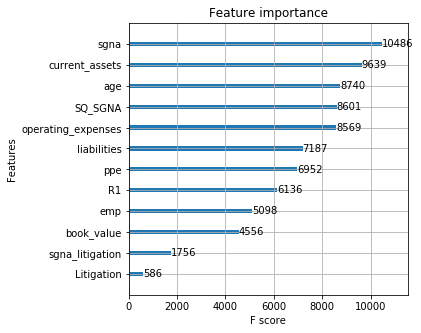

Effect of adding Moderating variable- Numbers and Interaction variable- sgna_no_of_cases
Mean Absolute Error: 373.1114855881395
Mean Squared Error: 895403.3663337899
Root Mean Squared Error: 946.2575581382639
R-squared: 0.9807440581563884


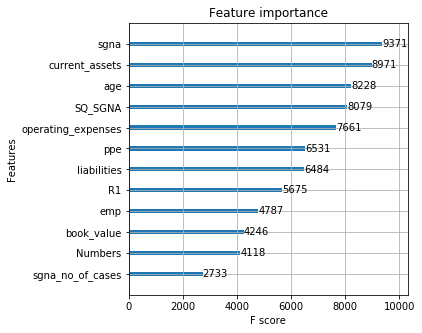

Effect of adding Moderating variable- developed and Interaction variable- sgna_developed
Mean Absolute Error: 329.4655221149839
Mean Squared Error: 582803.872888886
Root Mean Squared Error: 763.4159239162398
R-squared: 0.9874666123620576


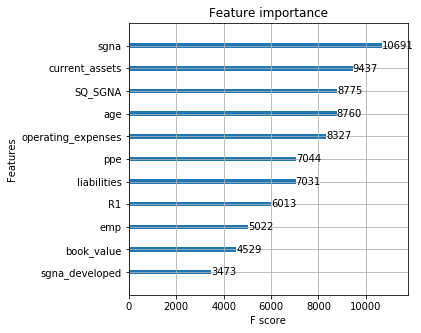

Effect of adding Moderating variable- Multinational and Interaction variable- sgna_multinational
Mean Absolute Error: 345.98289769271327
Mean Squared Error: 619843.6336729105
Root Mean Squared Error: 787.3014884228979
R-squared: 0.9866700602087205


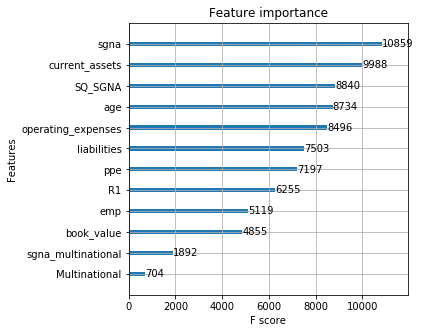

Effect of adding Moderating variable- Australia and Interaction variable- sgna_Australia
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


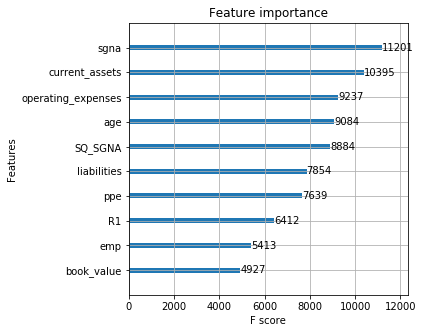

Effect of adding Moderating variable- Belgium and Interaction variable- sgna_Belgium
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


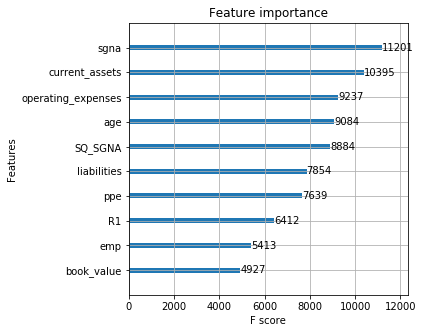

Effect of adding Moderating variable- Germany and Interaction variable- sgna_Germany
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


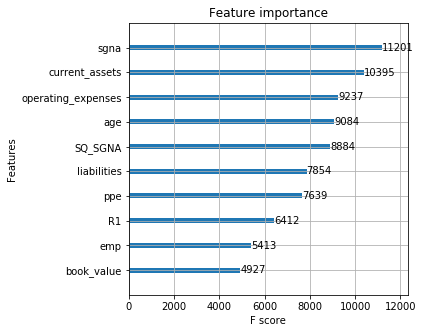

Effect of adding Moderating variable- India and Interaction variable- sgna_India
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


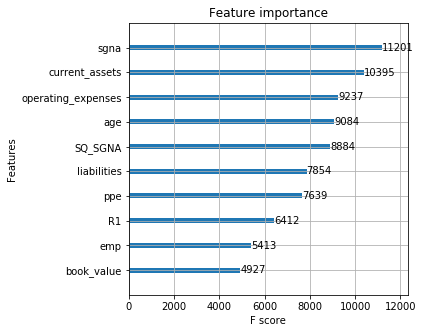

Effect of adding Moderating variable- Ireland and Interaction variable- sgna_Ireland
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


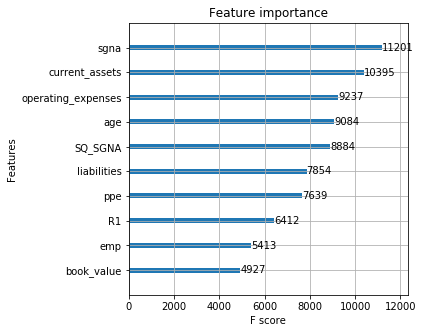

Effect of adding Moderating variable- Norway and Interaction variable- sgna_Norway
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


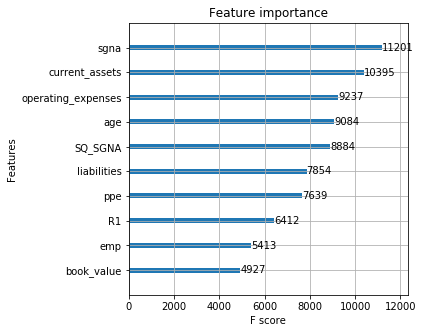

Effect of adding Moderating variable- Singapore and Interaction variable- sgna_Singapore
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


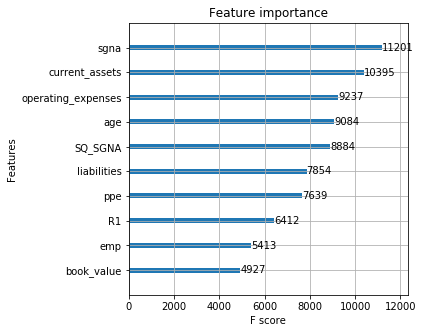

Effect of adding Moderating variable- Sweden and Interaction variable- sgna_Sweden
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


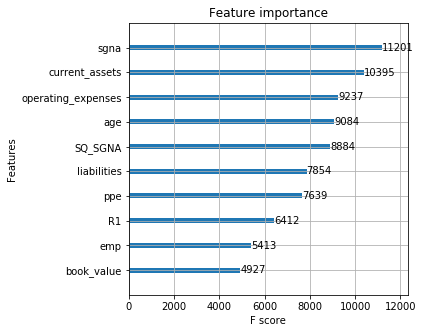

Effect of adding Moderating variable- UK and Interaction variable- sgna_UK
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


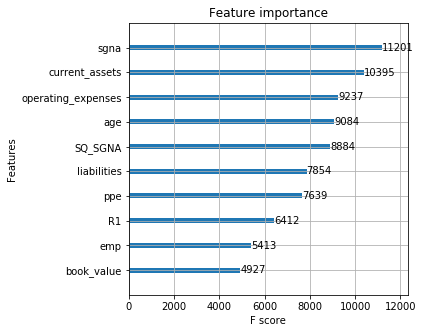

Effect of adding Moderating variable- USA and Interaction variable- sgna_USA
Mean Absolute Error: 329.4655221149839
Mean Squared Error: 582803.872888886
Root Mean Squared Error: 763.4159239162398
R-squared: 0.9874666123620576


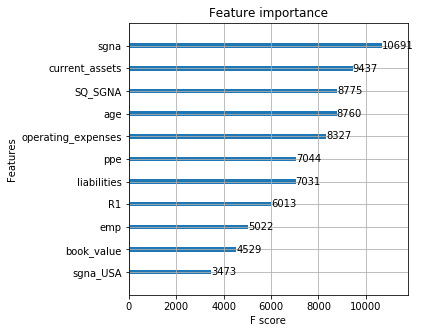

Effect of adding Moderating variable- policy_reforms_australia and Interaction variable- sgna_policy_reform_Australia
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


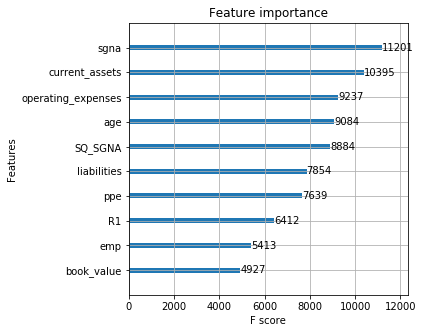

Effect of adding Moderating variable- policy_reforms_germany and Interaction variable- sgna_policy_reform_Germany
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


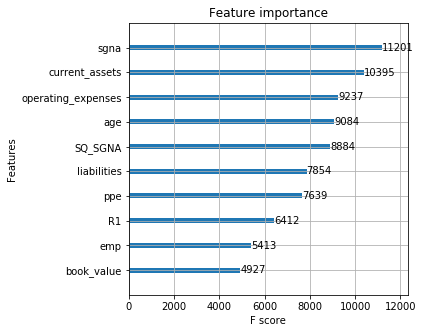

Effect of adding Moderating variable- policy_reforms_india and Interaction variable- sgna_policy_reform_India
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


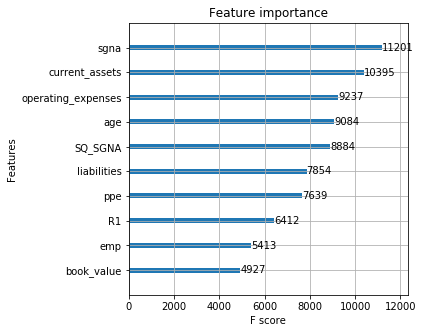

Effect of adding Moderating variable- policy_reforms_NORWAY and Interaction variable- sgna_policy_reform_Norway
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


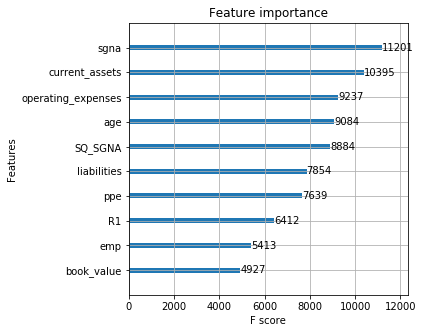

Effect of adding Moderating variable- policy_reforms_SINGAPORE and Interaction variable- sgna_policy_reform_Singapore
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


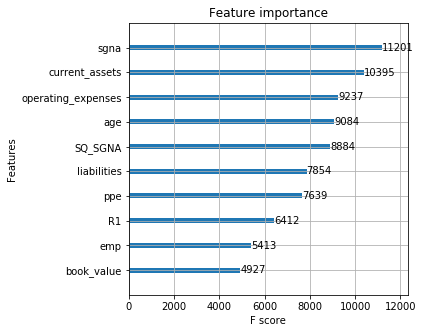

Effect of adding Moderating variable- policy_reforms_SWEDEN and Interaction variable- sgna_policy_reform_Sweden
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


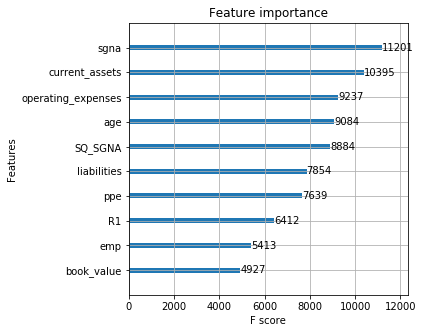

Effect of adding Moderating variable- policy_reforms_UK and Interaction variable- sgna_policy_reform_UK
Mean Absolute Error: 400.8663855914412
Mean Squared Error: 910836.5835313427
Root Mean Squared Error: 954.3775896003335
R-squared: 0.9804121617798618


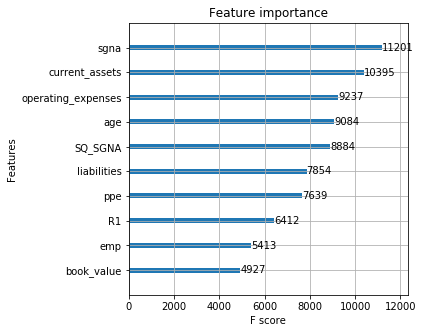

Effect of adding Moderating variable- policy_reforms_usa and Interaction variable- sgna_policy_reform_USA
Mean Absolute Error: 347.9670498486223
Mean Squared Error: 585953.89935249
Root Mean Squared Error: 765.4762565569816
R-squared: 0.9873988700141173


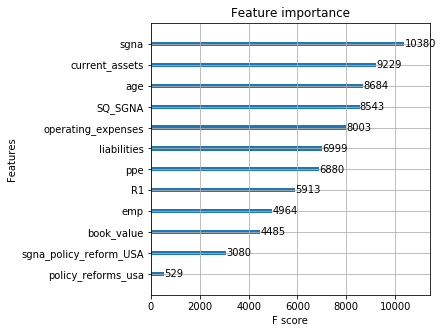

Effect of adding Moderating variable- GDP per capita growth (annual %) and Interaction variable- sgna_gdp per capita growth
Mean Absolute Error: 384.41006080857636
Mean Squared Error: 949727.4341433024
Root Mean Squared Error: 974.5396011159846
R-squared: 0.9795758013351845


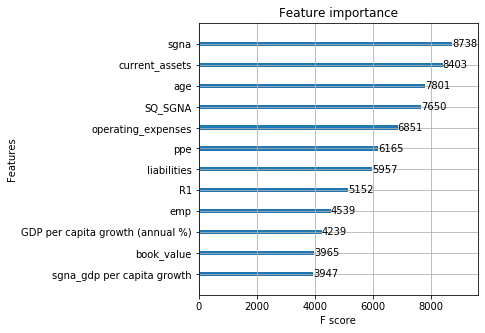

Effect of adding Moderating variable- Life expectancy at birth, total (years) and Interaction variable- sgna_life_expectancy
Mean Absolute Error: 325.8619224926521
Mean Squared Error: 573614.331684391
Root Mean Squared Error: 757.3733106496367
R-squared: 0.9876642364470861


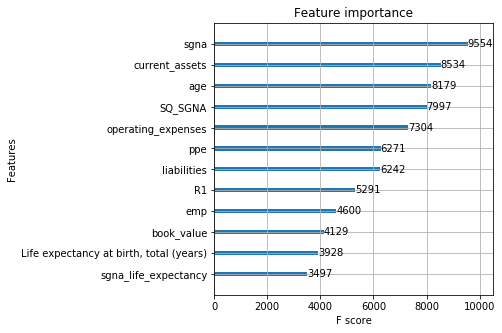

Effect of adding Moderating variable- Mortality rate, infant (per 1,000 live births) and Interaction variable- sgna_mortality
Mean Absolute Error: 304.7604153789323
Mean Squared Error: 500721.16575462045
Root Mean Squared Error: 707.6165386384214
R-squared: 0.9892318277882797


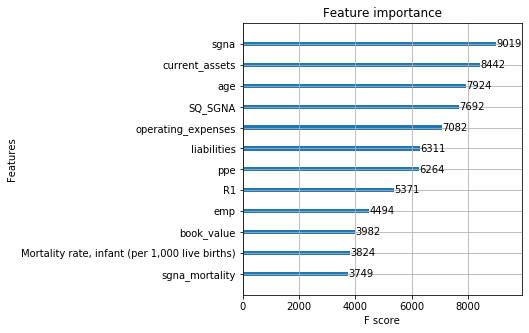

Effect of adding Moderating variable- Population, total and Interaction variable- sgna_population
Mean Absolute Error: 323.84991063413946
Mean Squared Error: 555171.0941742661
Root Mean Squared Error: 745.098043330048
R-squared: 0.9880608642935471


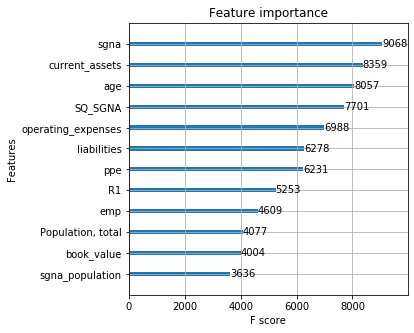

Effect of adding Moderating variable- Individuals using the Internet (% of population) and Interaction variable- sgna_Individuals_using _the_Internet
Mean Absolute Error: 361.8454490250555
Mean Squared Error: 759484.9569463732
Root Mean Squared Error: 871.484341194019
R-squared: 0.9836670279430182


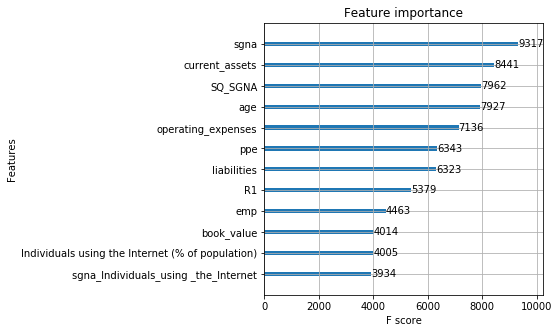

Effect of adding Moderating variable- Physicians (per 1,000 people) and Interaction variable- sgna_physicians
Mean Absolute Error: 337.0224882553364
Mean Squared Error: 652069.7142518985
Root Mean Squared Error: 807.5083369550425
R-squared: 0.9859770278204044


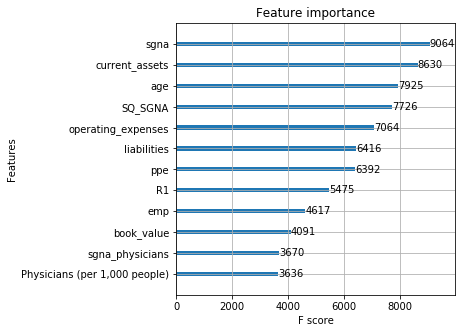

Effect of adding Moderating variable- acquisitions and Interaction variable- sgna_acquisitions
Mean Absolute Error: 386.883830313847
Mean Squared Error: 878193.133403236
Root Mean Squared Error: 937.119593970394
R-squared: 0.9811141698366501


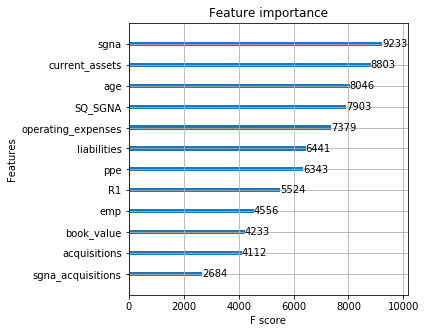

In [74]:
for i in range(0,29):
    X = df[IV+CV+[MV[i]]+[INT_V[i]]]
    y = df['gross_profit'].values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    xg=XGBoostReg(X_train,y_train,max_depth=50,objective ='reg:linear',n_estimators=400,learning_rate=0.1)
    print("Effect of adding Moderating variable-",MV[i],"and Interaction variable-", INT_V[i])
    pred=RegPredict(xg,X_test,y_test)

    xgb.plot_importance(xg)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()

### Bayesian Ridge Regression

#### Model without any Interaction and Moderating Variables

In [80]:
print("Bayesian Ridge Regression Results--Without Imputation")
br=BayesianRidgeReg(X_train,y_train)
pred=RegPredict(br,X_test,y_test)

Bayesian Ridge Regression Results--Without Imputation
Mean Absolute Error: 289.6819531101683
Mean Squared Error: 476285.08790458215
Root Mean Squared Error: 690.1341086372867
R-squared: 0.9897573336235915


#### Effect of adding each Moderating and Interacting Variable on the Model

In [87]:
for i in range(0,29):
    X = df[IV+CV+[MV[i]]+[INT_V[i]]]
    y = df['gross_profit'].values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    br=BayesianRidgeReg(X_train,y_train)
    print("Effect of adding Moderating variable-",MV[i],"and Interaction variable-", INT_V[i])
    pred=RegPredict(br,X_test,y_test)
    print("--------------------------------------------------------------------")

Effect of adding Moderating variable- Litigation and Interaction variable- sgna_litigation
Mean Absolute Error: 286.27453530441994
Mean Squared Error: 448837.17727255553
Root Mean Squared Error: 669.9531157271795
R-squared: 0.9903476099065845
--------------------------------------------------------------------
Effect of adding Moderating variable- Numbers and Interaction variable- sgna_no_of_cases
Mean Absolute Error: 293.0901533565016
Mean Squared Error: 470251.9338319194
Root Mean Squared Error: 685.7491770552258
R-squared: 0.9898870785724322
--------------------------------------------------------------------
Effect of adding Moderating variable- developed and Interaction variable- sgna_developed
Mean Absolute Error: 285.17435031290756
Mean Squared Error: 465693.90208573145
Root Mean Squared Error: 682.4176888722416
R-squared: 0.9899851005338476
--------------------------------------------------------------------
Effect of adding Moderating variable- Multinational and Interaction va